In [1]:
import torch
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score, mean_squared_error

from torch.autograd import Variable
import random

import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import KFold

In [2]:
print('GPU availability:', torch.cuda.is_available())

GPU availability: True


In [3]:
class prediction_model(nn.Module):

    def __init__(self, input_size, hidden1_size, hidden2_size, output_size):
        super(prediction_model, self).__init__()
        self.hidden1 = nn.Linear(input_size, hidden1_size)
        # self.dropout1 = nn.Dropout(p=0.1)
        self.batch1 = nn.BatchNorm1d(hidden1_size)

        self.hidden2 = nn.Linear(hidden1_size, hidden2_size)
        # self.dropout2 = nn.Dropout(p=0.001)
        self.batch2 = nn.BatchNorm1d(hidden2_size)

        # self.hidden3 = nn.Linear(hidden2_size, hidden3_size)
        # self.batch3 = nn.BatchNorm1d(hidden3_size)

        self.predict = nn.Linear(hidden2_size, output_size)
    
    def forward(self, input):
        result = self.hidden1(input)
        # result = self.dropout1(result)
        result = self.batch1(result)

        result = F.leaky_relu(result)

        result = self.hidden2(result)
        # result = self.dropout2(result)
        result = self.batch2(result)
        result = F.leaky_relu(result)

        # result = self.hidden3(result)
        # result = self.batch3(result)
        # result = F.leaky_relu(result)

        result = self.predict(result)

        return result

In [4]:
def train(model, x_data, y_data, optimizer, loss, epochs, device):

    final_R2_train = []
    final_R2_test = []
    final_rmse_train = []
    final_rmse_test = []


    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.2, random_state = 64)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # for train_index, val_index in kf.split(x_train):

    #     x_train_1, x_test_1 = x_train[train_index], x_train[val_index]
    #     y_train_1, y_test_1 = y_train[train_index], y_train[val_index]

    x_train_tensor = torch.tensor(x_train, dtype=torch.float32).cuda()
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).cuda()
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32).cuda()
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).cuda()

    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


    for epoch in range(epochs):
        model.train()

        mse_loss = []
        # define batch: batch_sizee = 100
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            optimizer.zero_grad()   # initialize gradient, gradient computed from batch 1 does not interfere batch2 and model update

            output = model(batch_x)
            l = loss(output, batch_y)

            mse_loss.append(l.item())   # l.item() 返回tensor中的每一个值，节约内存

            l.backward()     # back propagation
            optimizer.step()    # update model
        
        
        if epoch % 5 == 0:
            with torch.no_grad():
                model.eval()
                train_pred = model(batch_x.to(device)).cpu().numpy().flatten()
                r2_train = r2_score(batch_y, train_pred)
                rmse_train = np.sqrt(mean_squared_error(batch_y, train_pred))

                final_R2_train.append(r2_train)
                final_rmse_train.append(rmse_train)

                # final_R2_test.append()
                print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {np.mean(mse_loss)}, R2 Score (Train): {r2_train}, RMSE (Train): {rmse_train}")

                test_loss = []
                test_preds_list = []
                test_target_list = []
                for batch_x, batch_y in test_loader:
                    batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                    test_output = model(batch_x)
                    l = loss(test_output, batch_y)
                    test_loss.append(l.item())

                    test_preds_list.append(test_output.cpu().numpy())
                    test_target_list.append(batch_y.cpu().numpy())
                    
                test_preds = np.concatenate(test_preds_list).flatten()
                test_target = np.concatenate(test_target_list).flatten()

                r2_test = r2_score(test_target, test_preds)
                rmse_test = np.sqrt(mean_squared_error(test_target, test_preds))

                final_R2_test.append(r2_test)
                final_rmse_test.append(rmse_test)

                print(f"Test Loss: {np.mean(test_loss)}, R2 Score (Test): {r2_test}, RMSE (Test): {rmse_test}")

    return final_R2_test, final_R2_train, final_rmse_test, final_rmse_train

In [5]:
x_data = pd.read_csv('./Data/x_value_train.csv')
x_data = x_data.values
x_data.shape

(468, 1024)

In [24]:
y_data = pd.read_csv('./Data/y_value_train.csv')
y_data = y_data.values
# y_data

In [25]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device', device)
model = prediction_model(x_data.shape[1], 1024, 512, 1)
loss_func = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr = 0.00015, weight_decay = 1e-5)

model = model.to(device)
loss = loss_func.to(device)
epochs = 5000

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.2, random_state = 64)


final_R2_test, final_R2_train, final_rmse_test, final_rmse_train = train(model, x_data, y_data, optimizer, loss, epochs, device)

# for calculation
print('=========================================')
final_R2_train_sub = final_R2_train[20:]
final_R2_test_sub = final_R2_test[20:]
final_rmse_train_sub = final_rmse_train[20:]
final_rmse_test_sub = final_rmse_test[20:]
print(f'average R2 on training dataset:{np.mean(final_R2_train_sub)}, average R2 on testing dataset:{np.mean(final_R2_test_sub)}')
print(f'average rmse on training dataset:{np.mean(final_rmse_train_sub)}, average rmse on testing dataset:{np.mean(final_rmse_test_sub)}')

Using device cuda


Epoch [1/5000], Train Loss: 43.26290321350098, R2 Score (Train): -14.90602905694612, RMSE (Train): 6.758498191833496
Test Loss: 43.19074630737305, R2 Score (Test): -16.713536486666026, RMSE (Test): 6.601667881011963
Epoch [6/5000], Train Loss: 23.85483964284261, R2 Score (Train): -9.142537683401185, RMSE (Train): 5.4625244140625
Test Loss: 30.371487617492676, R2 Score (Test): -11.503276300154239, RMSE (Test): 5.546422958374023
Epoch [11/5000], Train Loss: 14.568433125813803, R2 Score (Train): -4.192687726750593, RMSE (Train): 3.7768473625183105
Test Loss: 16.75106716156006, R2 Score (Test): -5.915871295533533, RMSE (Test): 4.12500524520874
Epoch [16/5000], Train Loss: 8.73831049601237, R2 Score (Train): -2.04205989895645, RMSE (Train): 2.7948639392852783
Test Loss: 11.321361064910889, R2 Score (Test): -3.6718778505304552, RMSE (Test): 3.3903677463531494
Epoch [21/5000], Train Loss: 5.081542571385701, R2 Score (Train): -0.7886965657529086, RMSE (Train): 2.2135190963745117
Test Loss: 7.8

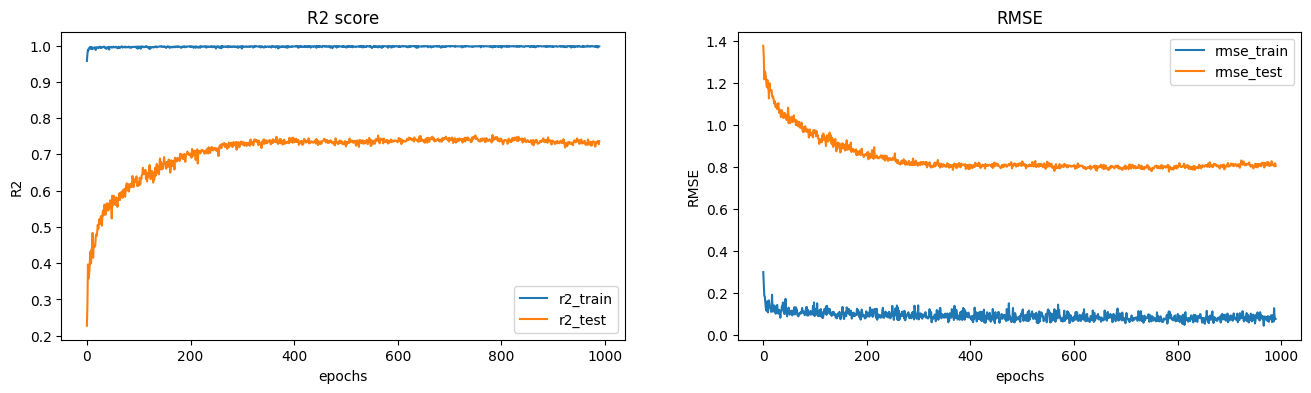

In [26]:
x = [i for i in range(990)]
fig = plt.figure(figsize=(16, 4))

# for plot
final_R2_train = final_R2_train[10:]
final_R2_test = final_R2_test[10:]
final_rmse_train = final_rmse_train[10:]
final_rmse_test = final_rmse_test[10:]

plt.subplot(1, 2, 1)
plt.plot(x, final_R2_train, label = 'r2_train')
plt.plot(x, final_R2_test, label = 'r2_test')
plt.legend()
plt.title('R2 score')
plt.xlabel('epochs')
plt.ylabel('R2')

plt.subplot(1, 2, 2)
plt.plot(x, final_rmse_train, label = 'rmse_train')
plt.plot(x, final_rmse_test, label = 'rmse_test')
plt.legend()
plt.title('RMSE')
plt.xlabel('epochs')
plt.ylabel('RMSE')

plt.show()

In [27]:
# torch.save(model, './model/ANN_model.pt')